<a href="https://colab.research.google.com/github/ngjingyang060103/Electricity-and-Cost-Analysis/blob/main/Python_File_Final_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Declaring Libraries

In [26]:

# declaring libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error


# Task 1: Data Cleaning Process
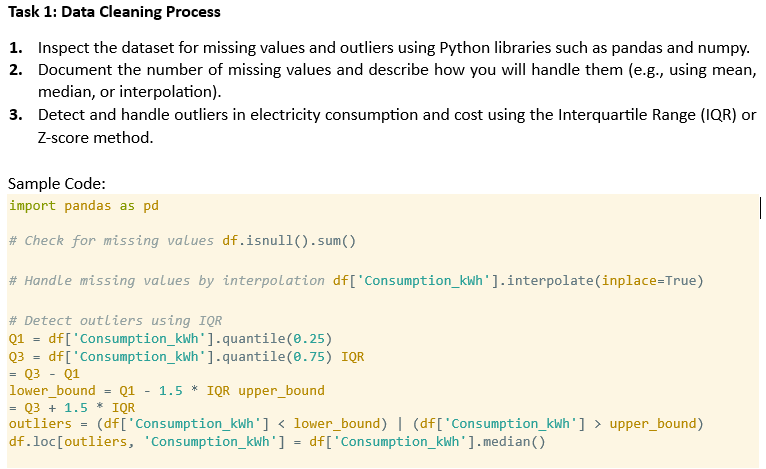

In [27]:
#------------------------------------
#Task 1: Data Cleaning Process
#-------------------------------------
#Read dataset
DATA_URL = "https://raw.githubusercontent.com/chongweiyang-hub/Electricity-and-Cost-Analysis/main/dataset_student_raw.csv"
df_1 = pd.read_csv(DATA_URL)

#---------- Missing Values ----------
print("\n===== Missing Values Summary =====")
print(df_1.isnull().sum(), "\n")

#Handle missing values
df_1['Consumption_kWh'] = df_1['Consumption_kWh'].interpolate()
df_1['Cost_RM'] = df_1['Consumption_kWh'] * 0.57
df_1['Occupants'] = df_1['Occupants'].fillna(df_1['Occupants'].median())

#---------- Outlier Detection ----------
print("===== Outlier Detection (IQR Method) =====\n")

#--- Consumption_kWh ---
print(">> Consumption_kWh Outliers by Region")
for region in df_1['Region'].unique():
  region_mask = df_1['Region'] == region

  Q1 = df_1.loc[region_mask, 'Consumption_kWh'].quantile(0.25)
  Q3 = df_1.loc[region_mask, 'Consumption_kWh'].quantile(0.75)
  IQR = Q3 - Q1

  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR
  outliers = (
    (df_1.loc[region_mask, 'Consumption_kWh'] < lower) |
    (df_1.loc[region_mask, 'Consumption_kWh'] > upper)
  )

  print(f"  • Region {region}: {outliers.sum()} outliers "
      f"(Lower={lower:.2f}, Upper={upper:.2f})")

# Treat outliers as NaN
df_1.loc[region_mask & outliers, 'Consumption_kWh'] = np.nan
#Interpolate outliers
df_1['Consumption_kWh'] = ( df_1.groupby('Region')['Consumption_kWh'] .transform(lambda x: x.interpolate()) )

#--- Cost_RM ---
print("\n>> Cost_RM Outliers by Region")
for region in df_1['Region'].unique():
  region_mask = df_1['Region'] == region
  Q1 = df_1.loc[region_mask, 'Cost_RM'].quantile(0.25)
  Q3 = df_1.loc[region_mask, 'Cost_RM'].quantile(0.75)
  IQR = Q3 - Q1

  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR

  outliers = (
    (df_1.loc[region_mask, 'Cost_RM'] < lower) |
    (df_1.loc[region_mask, 'Cost_RM'] > upper)
)
  print(f"  • Region {region}: {outliers.sum()} outliers "
      f"(Lower={lower:.2f}, Upper={upper:.2f})")
#Recalculate Cost_RM
df_1['Cost_RM'] = df_1['Consumption_kWh'] * 0.57

#---------- Save Cleaned Dataset ----------
df_1.to_csv("dataset_student_cleaned.csv", index=False)
print("\n Data cleaning completed. Cleaned dataset saved successfully.")




===== Missing Values Summary =====
Year               0
Month              0
Region             0
Consumption_kWh    5
Cost_RM            5
Occupants          5
dtype: int64 

===== Outlier Detection (IQR Method) =====

>> Consumption_kWh Outliers by Region
  • Region Urban: 1 outliers (Lower=373.20, Upper=633.29)
  • Region Suburban: 0 outliers (Lower=224.14, Upper=566.56)
  • Region Rural: 2 outliers (Lower=148.84, Upper=457.70)

>> Cost_RM Outliers by Region
  • Region Urban: 1 outliers (Lower=212.72, Upper=360.98)
  • Region Suburban: 0 outliers (Lower=127.76, Upper=322.94)
  • Region Rural: 2 outliers (Lower=84.84, Upper=260.89)

 Data cleaning completed. Cleaned dataset saved successfully.


# Task 2: Descriptive Data Analysis
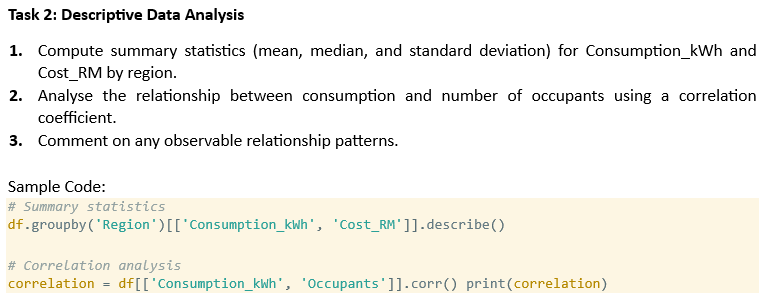

In [28]:
#-----------------------------------------
#   Task 2: Descriptive Data Analysis
#-----------------------------------------

# Load the original dataset (adjust file path as needed)
df_2= pd.read_csv('dataset_student_cleaned.csv')

#----Summary Statistics by Region----
# Computing mean, median, std for Consumption_kWh and Cost_RM grouped by Region
summary_stats = df_2.groupby('Region')[['Consumption_kWh', 'Cost_RM']].agg([
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Standard Deviation', 'std')]).round(2)
# Print the summary statistics with clear formatting
print("=" * 60)
print("Summary Statistics of Electricity Consumption and Cost by Region")
print("=" * 60)
print(summary_stats)
print("\n")

#----Relationship between consump and occupants----
#calculate correlation coefficient
correlation = (df_2['Consumption_kWh']).corr(df_2['Occupants'])
# Print correlation result
print("=" * 60)
print("Correlation Analysis: Occupants vs Electricity Consumption")
print("=" * 60)
print(f"Pearson Correlation Coefficient: {correlation:.4f}")
print("\n")


#----Relationship Pattern Comments----
print("=" * 60)
print("Relationship Pattern Comment")
print("=" * 60)

#---Regional Consumption/Cost Patterns---
# Read summary stats from each region
urban_consumption = summary_stats.loc['Urban', ('Consumption_kWh', 'Mean')]
suburban_consumption = summary_stats.loc['Suburban', ('Consumption_kWh', 'Mean')]
rural_consumption = summary_stats.loc['Rural', ('Consumption_kWh', 'Mean')]
# display observation
print(f"1. Regional Consumption: Urban households have the highest average consumption ({urban_consumption} kWh), "
      f"followed by Suburban ({suburban_consumption} kWh) and Rural ({rural_consumption} kWh) regions.")
print("This aligns with higher electricity demand from urban amenities and larger household appliances.\n")

#---Cost Pattern (derived from consumption, as Cost_RM = Consumption_kWh * 0.57)---
# gather cost_RM stats
urban_cost = summary_stats.loc['Urban', ('Cost_RM', 'Mean')]
rural_cost = summary_stats.loc['Rural', ('Cost_RM', 'Mean')]
# display observation
print(f"2. Regional Cost: Urban households have the highest average cost ({urban_cost} RM), "
      f"which is {urban_cost - rural_cost:.2f} RM higher than Rural households on average.\n")

#---Correlation Pattern---
# determine the correlation strength type
if correlation > 0.3:
    corr_strength = "moderate positive"
elif 0 < correlation <= 0.3:
    corr_strength = "weak positive"
elif correlation == 0:
    corr_strength = "no"
elif -0.3 <= correlation < 0:
    corr_strength = "weak negative"
else:
    corr_strength = "moderate negative"
# display observation
print(f"3. Occupancy-Consumption Relationship: There is a {corr_strength} correlation ({correlation:.4f}) "
      f"between the number of occupants and electricity consumption.")
print("This suggests that as household size increases, electricity usage tends to increase slightly.\n")

#---Variability Observation---
# gather standard deviation
urban_std = summary_stats.loc['Urban', ('Consumption_kWh', 'Standard Deviation')]
rural_std = summary_stats.loc['Rural', ('Consumption_kWh', 'Standard Deviation')]
# display observation
print(f"4. Variability: Urban households show higher consumption variability ({urban_std} kWh) compared to Rural "
      f"households ({rural_std} kWh), indicating more diverse usage patterns in urban areas.")
print("=" * 60)
print("\n\n\n")

Summary Statistics of Electricity Consumption and Cost by Region
         Consumption_kWh                            Cost_RM          \
                    Mean  Median Standard Deviation    Mean  Median   
Region                                                                
Rural             303.19  295.98              44.08  172.82  168.71   
Suburban          398.77  407.51              47.19  227.30  232.28   
Urban             508.36  501.47              72.79  289.77  285.84   

                             
         Standard Deviation  
Region                       
Rural                 25.13  
Suburban              26.90  
Urban                 41.49  


Correlation Analysis: Occupants vs Electricity Consumption
Pearson Correlation Coefficient: -0.4742


Relationship Pattern Comment
1. Regional Consumption: Urban households have the highest average consumption (508.36 kWh), followed by Suburban (398.77 kWh) and Rural (303.19 kWh) regions.
This aligns with higher electricity 

# Task 3: Data Visualisation
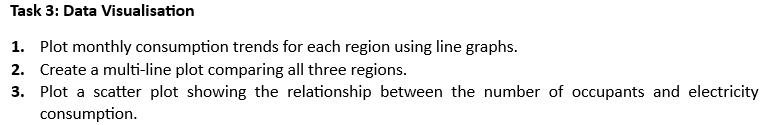

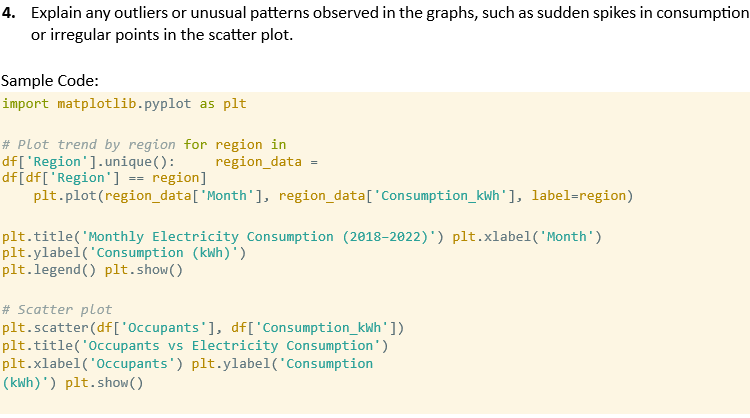

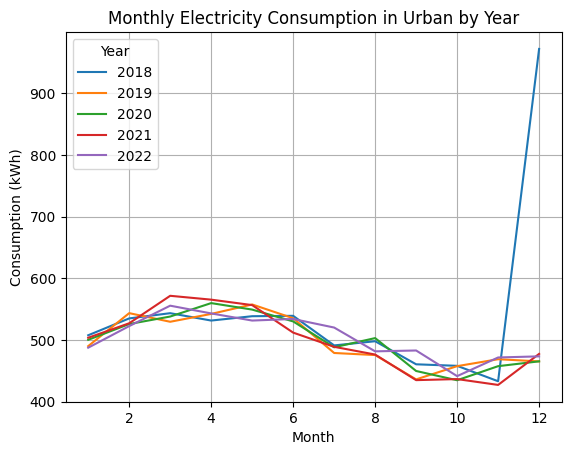

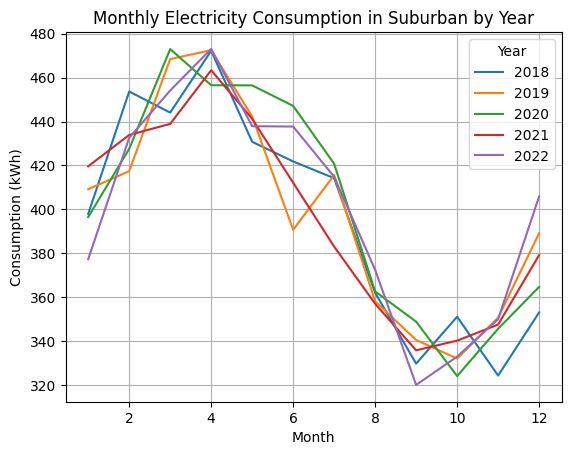

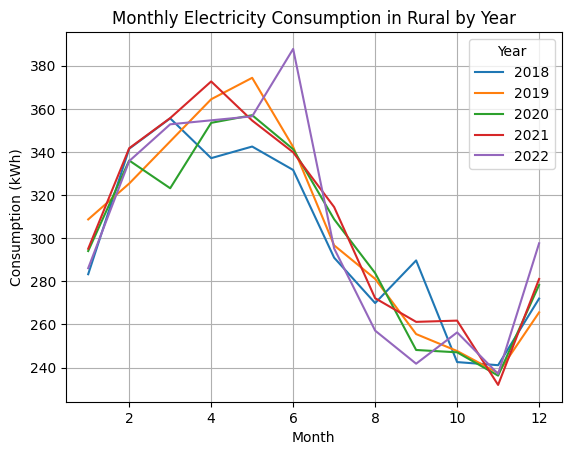

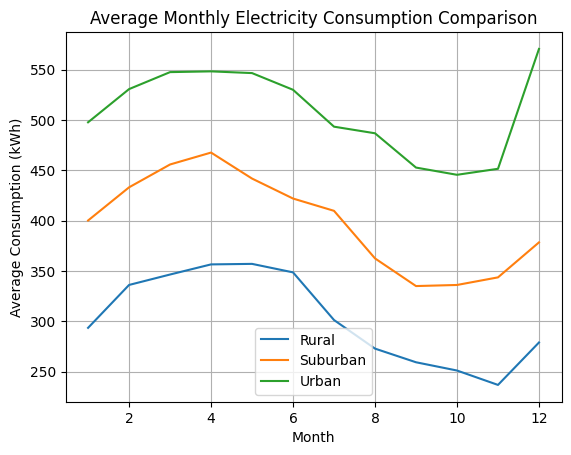

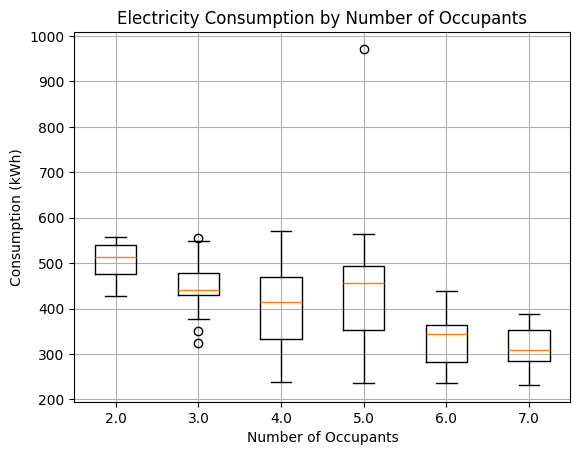

In [29]:
#-----------------------------------------
#   Task 3: Data Visualisation
#-----------------------------------------

# ================================
# 1. Monthly consumption trends for each region
# ================================
for region in df_2['Region'].unique():
    plt.figure()

    region_data = df_2[df_2['Region'] == region]

    for year in region_data['Year'].unique():
        year_data = region_data[region_data['Year'] == year]
        year_data = year_data.sort_values('Month')

        plt.plot(year_data['Month'], year_data['Consumption_kWh'], label=year)

    plt.title(f"Monthly Electricity Consumption in {region} by Year")
    plt.xlabel("Month")
    plt.ylabel("Consumption (kWh)")
    plt.legend(title="Year")
    plt.grid(True)
    plt.show()

# ================================
# 2. Multi-line plot comparing all regions (average consumption)
# ================================
avg_consumption = df_2.groupby(['Month', 'Region'])['Consumption_kWh'].mean().reset_index()

plt.figure()
for region in avg_consumption['Region'].unique():
    data = avg_consumption[avg_consumption['Region'] == region]
    plt.plot(data['Month'], data['Consumption_kWh'], label=region)

plt.title("Average Monthly Electricity Consumption Comparison")
plt.xlabel("Month")
plt.ylabel("Average Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 3. Scatter plot: Occupants vs Consumption
# ================================
import matplotlib.pyplot as plt

occupants = sorted(df_2['Occupants'].unique())

box_data = [df_2[df_2['Occupants'] == occ]['Consumption_kWh']
    for occ in occupants]

plt.figure()
plt.boxplot(box_data, tick_labels=occupants)
plt.title("Electricity Consumption by Number of Occupants")
plt.xlabel("Number of Occupants")
plt.ylabel("Consumption (kWh)")
plt.grid(True)
plt.show()

# Task 4: Predictive Analysis
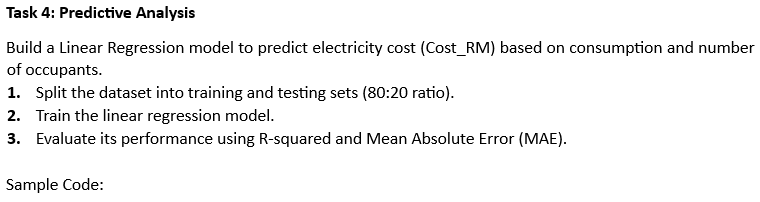

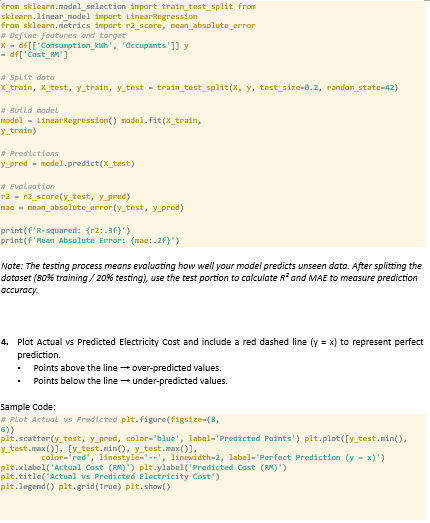

Linear Regression Model Performance Evaluation
R-squared (R²): 1.00
Mean Absolute Error (MAE): 0.00 RM




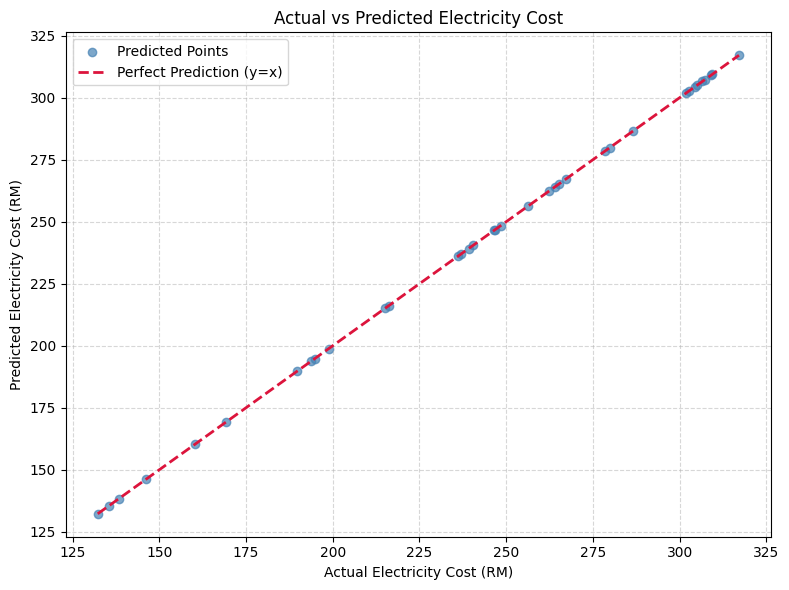

Prediction Result Interpretation
1. Model Fit: R² value (1.00) shows excellent fit to the data.
2. Prediction Error: On average, predictions are 0.00 RM off from actual cost.
3. Prediction Bias: 61.1% of predictions are higher than actual cost, 0.0% are lower.


In [30]:
#-----------------------------------------
#   Task 4: Predictive Analysis
#-----------------------------------------

# Select feature columns (input variables) - electricity consumption and number of occupants
features = df_2[['Consumption_kWh', 'Occupants']]

# Select target column (output variable) - electricity cost
target = df_2['Cost_RM']

# Split the dataset into training and testing sets
# Test size is 20% and random_state=42 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize a Linear Regression model
lr_model = LinearRegression()

# Fit the model using the training data
lr_model.fit(X_train, y_train)

# Predict target values for the test set
y_predicted = lr_model.predict(X_test)

# Calculate R-squared (R²) score to measure model's goodness-of-fit (closer to 1 is better)
r2_score_value = r2_score(y_test, y_predicted)

# Calculate Mean Absolute Error (MAE) to measure average prediction error
mae_value = mean_absolute_error(y_test, y_predicted)

# Print a separator and title for model evaluation
print("=" * 60)
print("Linear Regression Model Performance Evaluation")
print("=" * 60)

# Print R² score with 2 decimal places
print(f"R-squared (R²): {r2_score_value:.2f}")

# Print Mean Absolute Error with 2 decimal places
print(f"Mean Absolute Error (MAE): {mae_value:.2f} RM")
print("=" * 60)
print("\n")

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))

# Scatter plot of predicted vs actual points, semi-transparent blue
plt.scatter(y_test, y_predicted, color='steelblue', label='Predicted Points', alpha=0.7)

# Plot the perfect prediction line (y=x) as a red dashed line
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='crimson', linestyle='--', linewidth=2, label='Perfect Prediction (y=x)')

# Set x-axis label
plt.xlabel('Actual Electricity Cost (RM)')

# Set y-axis label
plt.ylabel('Predicted Electricity Cost (RM)')

# Set plot title
plt.title('Actual vs Predicted Electricity Cost')

# Add legend at upper left corner
plt.legend(loc='upper left')

# Add grid with dashed lines and semi-transparency
plt.grid(True, linestyle='--', alpha=0.5)

# Automatically adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

# Print separator and title for prediction interpretation
print("=" * 60)
print("Prediction Result Interpretation")
print("=" * 60)

# Determine the quality of model fit based on R² value
if r2_score_value >= 0.8:
    fit_quality = "excellent"  # very good fit
elif r2_score_value >= 0.6:
    fit_quality = "good"       # good fit
elif r2_score_value >= 0.4:
    fit_quality = "moderate"   # moderate fit
else:
    fit_quality = "poor"       # poor fit

# Print model fit evaluation
print(f"1. Model Fit: R² value ({r2_score_value:.2f}) shows {fit_quality} fit to the data.")

# Print average prediction error
print(f"2. Prediction Error: On average, predictions are {mae_value:.2f} RM off from actual cost.")

# Calculate percentage of predictions that overestimate the actual cost
over_pred_percent = (sum(y_predicted > y_test) / len(y_predicted)) * 100

# Calculate percentage of predictions that underestimate the actual cost
under_pred_percent = (sum(y_predicted < y_test) / len(y_predicted)) * 100

# Print prediction bias information
print(f"3. Prediction Bias: {over_pred_percent:.1f}% of predictions are higher than actual cost, "
      f"{under_pred_percent:.1f}% are lower.")
print("=" * 60)